In [1]:
import numpy as np
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preprocessing_modules as pm
import models as mm


In [2]:
enc=pm.ENCODE_data(cell_line='GM12878', assembly='hg19', res=100000 ,histones=False, total_rna=True, tf=False)

Selected cell line to predict: GM12878
Selected assembly: hg19
Selected signal type: signal p-value
Selected resolution:  100 kb


In [3]:
enc.download()

Number of replicas: 92


Process replicas: 100%|████████████████████████████████████████| 92/92 [03:20<00:00,  2.18s/it]


Experiments found in ENCODE for the selected cell line:
H2AFZ
H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me2
H3K4me3
H3K79me2
H3K9ac
H3K9me3
H4K20me1
RNA-seq-minus-total
RNA-seq-plus-total
Downoaded data stored at:  ENCODE_data/GM12878_hg19_100k


In [3]:
x_df,labels=enc.get_training_data(n_neighbor=2)

print(x_df.sample(5), len(labels),np.unique(labels))

Loading data from: ENCODE_data/GM12878_hg19_100k
There are 1 tracks: ['RNA']
Number of chromosomes:22

Normalizing data...
done!
          RNA_0    RNA_R1    RNA_L1    RNA_R2    RNA_L2
2227   0.227624  0.661347  0.098052  0.624449  0.061616
8567   0.557392  0.882672  0.564028  1.000000  0.675977
23563  0.065410  0.142105  0.056076  0.650807  0.444184
20358  0.018601  0.034040  0.055096  0.026534  0.029247
25115  0.045813  0.479208  0.050897  0.626614  0.057297 26226 [0. 1.]


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x_df.to_numpy(), labels, test_size=0.25, random_state=324)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(19669, 5) (19669,) (6557, 5) (6557,)


In [35]:
hyper_params={
    "learning_rate":0.001,
    "dropout_rate":0.2,
    "batch_size":32,
    "block_sizes":[64,64],
    "num_blocks":2,
    "validation_split":0.2,
    "useDropout": False,
    "useBatchNorm": False,
    "activation":"gelu",
    "initializer":"he_normal",
}

In [14]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [36]:
model = mm.baseFNNmodel(input_shape=X_train.shape[1], output_shape=len(np.unique(Y_train)), hyper_params=hyper_params)

model.summary()

Model: "baseFFN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 5)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 64)           4820        ['input_features[0][0]']         
                                                                                                  
 ffn_block3 (Sequential)        (None, 64)           8832        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection1 (Add)         (None, 64)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block3[0][0]']       

In [16]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=150, show_layer_names=True, show_layer_activations=True, rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
hist = mm.run_experiment(model, X_train, Y_train, X_test, Y_test, num_epochs=20, hyper_params=hyper_params)

Epoch 1/20


2022-11-03 00:13:17.065050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


492/492 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.8024

2022-11-03 00:13:29.697865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


492/492 [==============================] - 15s 26ms/step - loss: 0.4549 - accuracy: 0.8024 - val_loss: 0.3462 - val_accuracy: 0.8541
Epoch 2/20
492/492 [==============================] - 11s 23ms/step - loss: 0.3839 - accuracy: 0.8322 - val_loss: 0.3517 - val_accuracy: 0.8482
Epoch 3/20
492/492 [==============================] - 11s 23ms/step - loss: 0.3798 - accuracy: 0.8311 - val_loss: 0.3380 - val_accuracy: 0.8569
Epoch 4/20
492/492 [==============================] - 11s 22ms/step - loss: 0.3740 - accuracy: 0.8330 - val_loss: 0.3350 - val_accuracy: 0.8577
Epoch 5/20
492/492 [==============================] - 11s 22ms/step - loss: 0.3689 - accuracy: 0.8402 - val_loss: 0.3379 - val_accuracy: 0.8533
Epoch 6/20
492/492 [==============================] - 11s 22ms/step - loss: 0.3623 - accuracy: 0.8405 - val_loss: 0.3345 - val_accuracy: 0.8531
Epoch 7/20
492/492 [==============================] - 11s 22ms/step - loss: 0.3665 - accuracy: 0.8408 - val_loss: 0.3377 - val_accuracy: 0.8559
Epo

In [1]:
display_learning_curves(hist[0])

NameError: name 'display_learning_curves' is not defined

In [34]:
hist[1]

{'loss': 0.339745432138443,
 'accuracy': 0.85420161485672,
 'roc': 0.8535889883745906}

In [16]:
inputs = keras.Input(shape=X_train.shape[1])

# x1 = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu",bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu", bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.add([x,x1])
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(np.unique(Y_train)), activation='relu')(x)

# del model
model = keras.Model(name="Predict-Chromatin-Types", inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=["accuracy"],
)

Model: "Predict-Chromatin-Types"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                384       
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 17,285
Trainable params: 17,2

In [17]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

Epoch 1/60
  1/246 [..............................] - ETA: 1:13 - loss: 0.8607 - accuracy: 0.1719

2022-11-02 03:06:05.454435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2102

2022-11-02 03:06:08.126990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 3s 12ms/step - loss: 0.4521 - accuracy: 0.2102 - val_loss: 0.3746 - val_accuracy: 0.2214
Epoch 2/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3903 - accuracy: 0.2155 - val_loss: 0.3842 - val_accuracy: 0.2201
Epoch 3/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3853 - accuracy: 0.2151 - val_loss: 0.3798 - val_accuracy: 0.2171
Epoch 4/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3801 - accuracy: 0.2201 - val_loss: 0.3680 - val_accuracy: 0.2199
Epoch 5/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3789 - accuracy: 0.2151 - val_loss: 0.3613 - val_accuracy: 0.2239
Epoch 6/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3725 - accuracy: 0.2199 - val_loss: 0.3697 - val_accuracy: 0.2194
Epoch 7/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3745 - accuracy: 0.2158 - val_loss: 0.3816 - val_accuracy: 0.2145
Epoch 8/60

KeyboardInterrupt: 

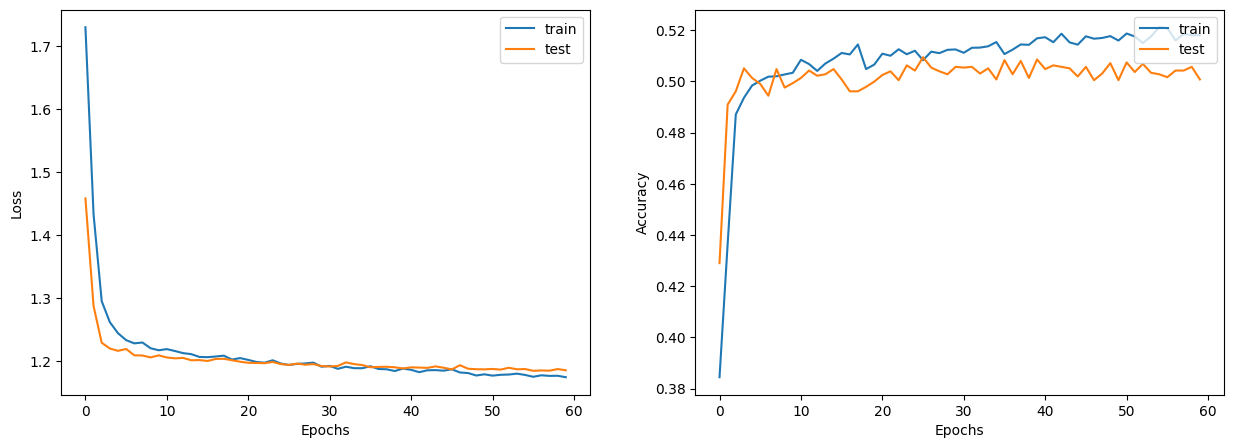

In [20]:
display_learning_curves(history)

In [ ]:
print(Y_test.shape, X_test.shape)
type_test={}

for val in np.unique(Y_test):
    ind = np.where(Y_test==val)[0]
    X_type=X_test[ind,:]
    Y_type=Y_test[ind]
    name=list(map(data.int_to_type.get, [val]))[0]

    print(name, Y_type.shape, X_type.shape)
    type_test[name] = (X_type,Y_type)

print(type_test.keys())


for key in type_test.keys():
    print("Type: ", key)
    test_scores = model.evaluate(type_test[key][0], type_test[key][1], verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])

In [6]:
a={'g':4}
assert 'g' in a